In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Conv2D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
import en_core_web_md
nlp = en_core_web_md.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

EDA

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train.shape

(7613, 5)

Les valeurs manquantes de la colonne "keyword" représentent moins de 1% du dataset, on la conserve.
Nous éliminons la colonne "location" pour avoir trop de valeurs manquantes.

In [7]:
train = train[[col for col in train.columns if col != 'location']]
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

On remplace les "%20" par un espace.

In [9]:
def replace20(x):
    
    try: 
        return x.replace('%20',' ')
    except AttributeError:
        return x

train['keyword'] = train['keyword'].apply(replace20)

train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.groupby('keyword')['target'].mean().sort_values(ascending = False)

keyword
debris        1.000000
wreckage      1.000000
derailment    1.000000
outbreak      0.975000
oil spill     0.973684
                ...   
body bag      0.030303
blazing       0.029412
ruin          0.027027
body bags     0.024390
aftershock    0.000000
Name: target, Length: 221, dtype: float64

In [11]:
train["text"] = train["text"].apply(lambda x: str(x).lower())

In [12]:
train['is arobase']= train['text'].apply(lambda x:str(x).find('@') != -1).astype(int)

In [13]:
train['is arobase'].mean()

0.26783134112701956

In [14]:
print('Si le tweet contient @, alors la probabilité qu\'il \
indique une catastrophe naturelle est' , round(train.groupby('is arobase')['target'].mean().loc[1],2))

print('Si le tweet ne contient pas @, alors la probabilité qu\'il \
indique une catastrophe naturelle est' , round(train.groupby('is arobase')['target'].mean().loc[0],2))

Si le tweet contient @, alors la probabilité qu'il indique une catastrophe naturelle est 0.33
Si le tweet ne contient pas @, alors la probabilité qu'il indique une catastrophe naturelle est 0.47


In [15]:
train['is hashtag'] = train['text'].apply(lambda x:str(x).find('#') != -1).astype(int)

train['is hashtag'].mean()

0.2313148561670826

In [16]:
print('Si le tweet contient #, alors la probabilité qu\'il \
indique une catastrophe naturelle est' , round(train.groupby('is hashtag')['target'].mean().loc[1],2))

print('Si le tweet ne contient pas #, alors la probabilité qu\'il \
indique une catastrophe naturelle est' , round(train.groupby('is hashtag')['target'].mean().loc[0],2))

Si le tweet contient #, alors la probabilité qu'il indique une catastrophe naturelle est 0.5
Si le tweet ne contient pas #, alors la probabilité qu'il indique une catastrophe naturelle est 0.41


In [17]:
train.sample(15)

,id,keyword,text,target,is arobase,is hashtag
4024,5715,forest fire,our little forest fire wardens http://t.co/apr...,1,0,0
6401,9148,suicide bomber,#isis claims responsibility for saudi suicide ...,1,0,1
2297,3296,demolish,think i'll become a businessman a demolish a c...,0,0,0
7599,10854,NaN,1.3 #earthquake in 9km ssw of anza california ...,1,0,1
6726,9639,thunderstorm,severe thunderstorm warning for oklahoma count...,1,0,1
6499,9292,survive,hank williams jr. - 'country boys can survive'...,0,1,0
1182,1702,bridge collapse,australia's ashes disaster - how the collapse ...,1,0,0
7157,10255,war zone,thank you to @scegnews! our neighborhood looks...,1,1,0
6459,9240,suicide bombing,1 of the major reason of suicide bombing is th...,1,0,0
3696,5259,fatality,fatality ????,0,0,0


Pre-processing

In [18]:
train['text'] = train['text'].apply(unidecode)

In [19]:
train

,id,keyword,text,target,is arobase,is hashtag
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1
1,4,NaN,forest fire near la ronge sask. canada,1,0,0
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1
...,...,...,...,...,...,...
7608,10869,NaN,two giant cranes holding a bridge collapse int...,1,0,0
7609,10870,NaN,@aria_ahrary @thetawniest the out of control w...,1,1,0
7610,10871,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,0,0
7611,10872,NaN,police investigating after an e-bike collided ...,1,0,0


In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def remove_stop_words2(dataset):
  data = tc.document(dataset)
  new_data = data.remove_stpwrds()
 
  list_new = [word for word in new_data]

  while '' in list_new:
    list_new.remove('')
  
  return list_new


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text) 
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [21]:
train['token_text'] = train['text'].apply(clean_text)

train['text_cleaned'] = train['token_text'].apply(lambda x : " ".join(x))
train

,id,keyword,text,target,is arobase,is hashtag,token_text,text_cleaned
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1,"[deed, reason, #, earthquake, allah, forgive]",deed reason # earthquake allah forgive
1,4,NaN,forest fire near la ronge sask. canada,1,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1,"[people, receive, #, wildfire, evacuation, ord...",people receive # wildfire evacuation order cal...
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1,"[got, send, photo, ruby, #, alaska, smoke, #, ...",got send photo ruby # alaska smoke # wildfire ...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,two giant cranes holding a bridge collapse int...,1,0,0,"[giant, crane, hold, bridge, collapse, nearby,...",giant crane hold bridge collapse nearby home
7609,10870,NaN,@aria_ahrary @thetawniest the out of control w...,1,1,0,"[@, ariaahrary, @, thetawni, control, wild, fi...",@ ariaahrary @ thetawni control wild fire cali...
7610,10871,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,0,0,"[m, [, utc], km, volcano, hawaii]",m [ utc] km volcano hawaii
7611,10872,NaN,police investigating after an e-bike collided ...,1,0,0,"[police, investigate, e, bike, collide, car, l...",police investigate e bike collide car little p...


In [23]:
def clean_keyword(x):
    
    try:
        clean_token = clean_text(x)
        return " ".join(clean_token)
    except ValueError:
        return ""

train['keyword_cleaned'] = train['keyword'].apply(clean_keyword)

In [24]:
train.iloc[:,[1,-1]].sample(16)

,keyword,keyword_cleaned
2639,destruction,destruction
3086,electrocute,electrocute
5636,refugees,refugee
6283,storm,storm
7608,NaN,
2606,destroyed,destroy
2574,destroy,destroy
5538,radiation emergency,radiation emergency
7021,typhoon,typhoon
1651,collapsed,collapse


In [25]:
train['keyword_text_cleaned'] = train.keyword_cleaned + ' ' + train.text_cleaned

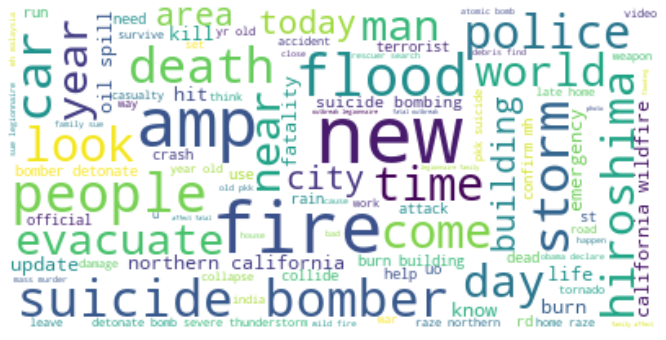

In [26]:
import matplotlib.pyplot as plt

text = " ".join(review for review in train[train['target'] == 1]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

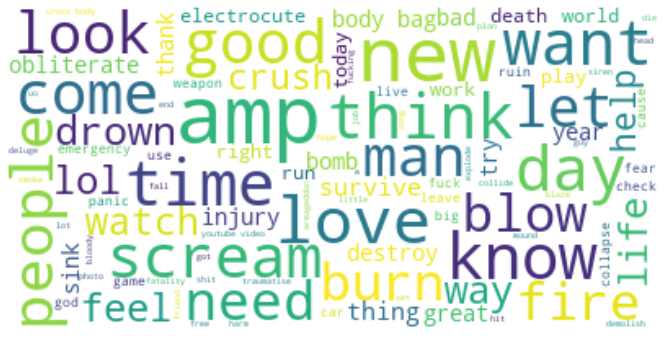

In [27]:
text = " ".join(review for review in train[train['target'] == 0]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [29]:
list_words_df3_label1 = []

for words in train[train['target'] == 1]['token_text'].tolist():
    list_words_df3_label1 += words

list_words_df3_label0 = []

for words in train[train['target'] == 0]['token_text'].tolist():
    list_words_df3_label0 += words

In [31]:
pd.DataFrame({'words':list_words_df3_label1}).value_counts().sort_values(ascending = False)[:10]

words     
#             1679
@              885
fire           268
kill           156
news           141
disaster       121
california     115
bomb           113
year           112
crash          112
dtype: int64

In [32]:
pd.DataFrame({'words':list_words_df3_label0}).value_counts().sort_values(ascending = False)[:10]

words
@        1827
#        1670
amp       193
new       172
good      120
body      119
love      117
come      108
time      106
video     103
dtype: int64

Train models

In [33]:
train['target'].mean()

0.4296597924602653

Il s'agit d'un dataframe déséquilibré

Model 1: avec les arobases et les hashtags

In [34]:
df = train.copy()

In [35]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.keyword_text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [36]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['target'].values

In [37]:
keyword_pad1 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer1.texts_to_sequences(df1.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad1 = np.concatenate([keyword_pad1,text_pad1],axis = 1)

In [38]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [39]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 4, # the number of neurons on the convolutional layer
kernel_size = (5), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "valid", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [40]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 conv1d (Conv1D)             (None, 13, 4)             2564      
                                                                 
 global_average_pooling1d (G  (None, 4)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 16)                816       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

In [41]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=20, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/20
50/50 [==============================] - 2s 13ms/step - loss: 0.2835 - mean_absolute_error: 0.4966 - val_loss: 0.2543 - val_mean_absolute_error: 0.4912
Epoch 2/20
50/50 [==============================] - 0s 7ms/step - loss: 0.2367 - mean_absolute_error: 0.4762 - val_loss: 0.2090 - val_mean_absolute_error: 0.4401
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 0.1796 - mean_absolute_error: 0.3747 - val_loss: 0.1635 - val_mean_absolute_error: 0.3249
Epoch 4/20
50/50 [==============================] - 0s 7ms/step - loss: 0.1494 - mean_absolute_error: 0.3030 - val_loss: 0.1540 - val_mean_absolute_error: 0.3063
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.1351 - mean_absolute_error: 0.2776 - val_loss: 0.1526 - val_mean_absolute_error: 0.2953
Epoch 6/20
50/50 [==============================] - 0s 7ms/step - loss: 0.1320 - mean_absolute_error: 0.2670 - val_loss: 0.1529 - val_mean_absolute_error: 0.2834
Epoch 7/20
50/50 [=========

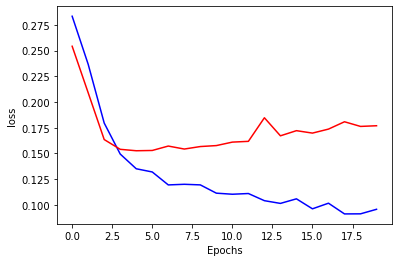

In [42]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [43]:
df['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [44]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [45]:
np.array(y_train).mean()

0.4318834179730625

In [46]:
np.array(y_val).mean()

0.43178807947019865

In [47]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.9068226981673658
accuracy score test : 0.7741721854304636
f1 score train : 0.8857606930157012
f1 score test : 0.7261044176706828


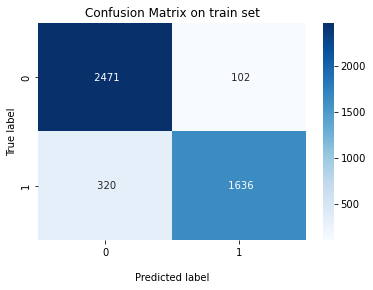

In [48]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

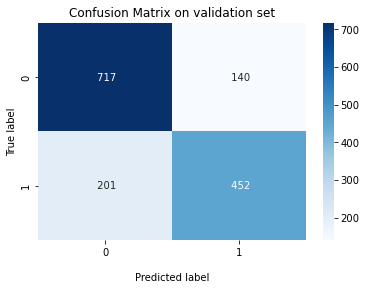

In [49]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on validation set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
df1['pred prob target'] = model1.predict(text_pad1)
df1['pred target'] = df1['pred prob target'].apply(lambda x : x>0.5)

236/236 [==============================] - 0s 2ms/step


In [51]:
size = ((df1.target == 1)&(df1['pred target'] == 0)).sum()

idx = np.random.randint(size)

df1[(df1.target == 1)&(df1['pred target'] == 0)].iloc[idx]['text']

'airplane crashes on house in colombia 12 people die in accident https://t.co/zhjlflbhzl'

Model2: same model than model1 but we eliminate the arobases and hashtags

In [52]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

In [53]:
tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer2.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer2.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

In [54]:
df2 = df_bis[df_bis["len_text"]!=0]

text_pad2 = tf.keras.preprocessing.sequence.pad_sequences(df2.text_encoded, padding="post")

y = df2['target'].values

In [55]:
keyword_pad2 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(df2.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad2 = np.concatenate([keyword_pad2,text_pad2],axis = 1)

In [56]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad2,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [57]:
vocab_size = tokenizer2.num_words
model2 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 4, # the number of neurons on the convolutional layer
kernel_size = (5), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "valid", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = None # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [58]:
optimizer= keras.optimizers.Adam()

model2.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model2.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 1s 10ms/step - loss: 0.2411 - mean_absolute_error: 0.4868 - val_loss: 0.2283 - val_mean_absolute_error: 0.4688
Epoch 2/15
50/50 [==============================] - 0s 8ms/step - loss: 0.1953 - mean_absolute_error: 0.4248 - val_loss: 0.1702 - val_mean_absolute_error: 0.3810
Epoch 3/15
50/50 [==============================] - 0s 7ms/step - loss: 0.1464 - mean_absolute_error: 0.3273 - val_loss: 0.1514 - val_mean_absolute_error: 0.3187
Epoch 4/15
50/50 [==============================] - 0s 6ms/step - loss: 0.1267 - mean_absolute_error: 0.2771 - val_loss: 0.1496 - val_mean_absolute_error: 0.2921
Epoch 5/15
50/50 [==============================] - 0s 7ms/step - loss: 0.1176 - mean_absolute_error: 0.2568 - val_loss: 0.1499 - val_mean_absolute_error: 0.2802
Epoch 6/15
50/50 [==============================] - 0s 7ms/step - loss: 0.1135 - mean_absolute_error: 0.2406 - val_loss: 0.1512 - val_mean_absolute_error: 0.2764
Epoch 7/15
50/50 [=========

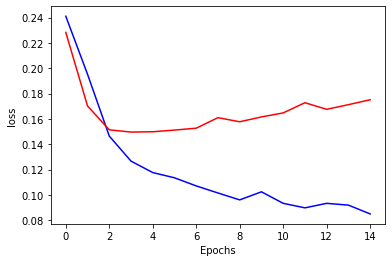

In [59]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [60]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [61]:
print('accuracy score train :', accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :', accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.9037315080591742
accuracy score test : 0.776158940397351
f1 score train : 0.8857442348008385
f1 score test : 0.7383900928792569


The results are worse. We test a new model where tokenizer is used with a tfidf.

model2a

In [62]:
tokenizer3 = tf.keras.preprocessing.text.Tokenizer(num_words=500) # instanciate the tokenizer
tokenizer3.fit_on_texts(df.keyword_text_cleaned)

df3 = df.copy()

df3['text_encoded'] = np.array(df3.text_cleaned.apply(lambda x : tokenizer3.texts_to_matrix(x,mode = 'tfidf')))

In [63]:
df3['len_encoded'] = df3['text_encoded'].apply(lambda x : x.shape[0])

In [64]:
df3 = df3[df3['len_encoded']>0]

In [65]:
tweet_pads3 = tf.keras.preprocessing.sequence.pad_sequences(df3.text_encoded, padding="post")

In [66]:
tweet_pads3.shape

(7612, 137, 500)

In [68]:
keyword_pads3 = tf.keras.preprocessing.sequence.pad_sequences(\
np.array(df3.keyword_cleaned.apply(lambda x : tokenizer3.texts_to_matrix(x,mode = 'tfidf'))),\
                                              padding = "post")

In [69]:
keyword_tweet_pads3 = np.concatenate([keyword_pads3,tweet_pads3],axis = 1)

In [70]:
y = df3['target']

In [71]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_tweet_pads3,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [72]:
X_test.shape

(1522, 156, 500)

In [73]:
model3 = keras.models.Sequential()

model3.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],\
                                                                             X_train.shape[2])))
model3.add(keras.layers.GlobalAveragePooling1D())

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(1000,)))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [74]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 154, 64)           96064     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                      

In [75]:
optimizer= keras.optimizers.Adam()

model3.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [76]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=30, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/30
50/50 [==============================] - 7s 118ms/step - loss: 0.3715 - mean_absolute_error: 0.4947 - val_loss: 0.3302 - val_mean_absolute_error: 0.4925
Epoch 2/30
50/50 [==============================] - 5s 106ms/step - loss: 0.3045 - mean_absolute_error: 0.4902 - val_loss: 0.2809 - val_mean_absolute_error: 0.4841
Epoch 3/30
50/50 [==============================] - 7s 131ms/step - loss: 0.2628 - mean_absolute_error: 0.4662 - val_loss: 0.2569 - val_mean_absolute_error: 0.4648
Epoch 4/30
50/50 [==============================] - 7s 140ms/step - loss: 0.2477 - mean_absolute_error: 0.4580 - val_loss: 0.2446 - val_mean_absolute_error: 0.4619
Epoch 5/30
50/50 [==============================] - 6s 116ms/step - loss: 0.2367 - mean_absolute_error: 0.4491 - val_loss: 0.2410 - val_mean_absolute_error: 0.4523
Epoch 6/30
50/50 [==============================] - 6s 124ms/step - loss: 0.2354 - mean_absolute_error: 0.4531 - val_loss: 0.2400 - val_mean_absolute_error: 0.4526
Epoch 7/30
50/50

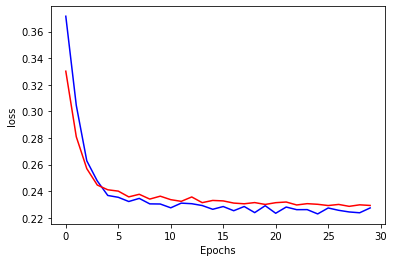

In [77]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [78]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

48/48 [==============================] - 2s 39ms/step


In [79]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.6509743814320123
accuracy score test : 0.6412614980289093
f1 score train :  0.5851119208745444
f1 score test :  0.5734375


Results are horribles. We use model1 in order to make prediction on sample_submission.csv

In [80]:
sample = pd.read_csv('sample_submission.csv')

In [81]:
test = pd.read_csv('test.csv')

In [82]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [83]:
test['keyword'] = test['keyword'].apply(replace20)

In [84]:
test['text_cleaned']=test['text'].apply(clean_text).apply(lambda x : " ".join(x))
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear # earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting # spokane # wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [85]:
test['keyword_cleaned'] = test['keyword'].apply(clean_keyword)
test.sample(15)

,id,keyword,location,text,text_cleaned,keyword_cleaned
1367,4501,emergency,USA,Motors Hot Deals #452 &gt;&gt; http://t.co/vca...,motors hot deals # gtgt manual transmission sh...,emergency
1706,5762,forest fires,"Panama City Beach, Florida",A group of Florida Forest Service firefighters...,group florida forest service firefighter deplo...,forest fire
2393,7998,razed,NaN,The Latest: More Homes Razed by Northern Calif...,late homes raze northern california wildfire a...,raze
1134,3740,destroyed,Rome,By havin an ally lyk @AnnCoulter Republican Pa...,havin ally lyk @ anncoulter republican party d...,destroy
2104,7055,meltdown,NaN,@rymathieson are you coming to meltdown!,@ rymathieson come meltdown,meltdown
1344,4433,electrocute,NaN,Eh it's the Macy's Thanksgiving Parade tomorro...,eh macy thanksgiving parade tomorrow electrocu...,electrocute
2842,9427,survivors,"Hollywood, CA",@TheNerdsofColor @GeorgeTakei narrates our new...,@ thenerdsofcolor @ georgetakei narrate new do...,survivor
612,1998,bush fires,NaN,Bushfire causes first victim in Albania :: Th...,bushfire cause victim albania multiple fire al...,bush fire
1823,6161,hijack,????? ?? ?????? -????? ????,Swansea ?plot hijack transfer move for Southam...,swansea plot hijack transfer southampton targe...,hijack
1236,4066,displaced,magodo,#mightyworld Thousands displaced after monsoon...,# mightyworld thousand displace monsoon rain m...,displace


In [86]:
test['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [87]:
text_encoded = tokenizer1.texts_to_sequences(test.text_cleaned)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_encoded, padding="post")
text_pad[:5,:]

array([[276,  79,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [218,  99, 927, 204, 402,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 78,   1, 527, 421, 155,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [207,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 95, 514,  24, 394, 932,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [88]:
text_pad.shape

(3263, 15)

In [89]:
keywords_encoded = tokenizer1.texts_to_sequences(test.keyword_cleaned)
keyword_pad = tf.keras.preprocessing.sequence.pad_sequences(keywords_encoded, padding="post")
keyword_pad.shape

(3263, 2)

In [90]:
keyword_text_pad = np.concatenate([keyword_pad,text_pad],axis = 1)
keyword_text_pad.shape

(3263, 17)

In [91]:
sample['target']=(model1.predict(keyword_text_pad)>0.5).astype(int)

102/102 [==============================] - 0s 2ms/step


In [92]:
sample.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,1
4,11,1


In [93]:
predict1 = sample[sample.target == 1].index

In [94]:
idx = np.random.randint(len(predict1))

test.loc[predict1].iloc[idx]['text']

'Heat wave adding to the misery of internally-displaced Gazans http://t.co/jW3hN9ewFT via @PressTV http://t.co/NYWrkRQ7Kn'

In [95]:
predict0 = sample[sample.target == 0].index

idx = np.random.randint(len(predict1))

test.loc[predict0].iloc[idx]['text']


'Wish I could buy a device that would electrocute me every time I went to eat something unhealthy....Eat so much shit.??????????'

In [97]:
sample.to_csv('sample_submission.csv')